### Step 1: Preprocess the Data

In [1]:
import pandas as pd

# Load training
file_path = './data/training_data/learning_all_moves.csv'
df_train = pd.read_csv(file_path, index_col='iteration')

# Load test data
file_path = './data/test_data/learning_all_moves.csv'
df_test = pd.read_csv(file_path, index_col='iteration')

# Load your data
file_path = './data/validation_data/learning_all_moves.csv'
df_val = pd.read_csv(file_path, index_col='iteration')

# Group by 'orig_ds_id' and sort within each group if necessary
grouped_train = df_train.groupby('orig_ds_id')
grouped_test = df_test.groupby('orig_ds_id')
grouped_val = df_val.groupby('orig_ds_id')


/var/folders/1s/5_jwsmtn2n54h333qvdtr32c0000gp/T/ipykernel_6494/2755568164.py:5: DtypeWarning: Columns (5,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(file_path, index_col='iteration')


In [2]:
df_val

,prune_name,rgft_name,orig_ds_ll,ll_prune,time_prune,d_ll_prune,edge_length_prune,longest_branch_prune,tbl_pruned_prune,tbl_remaining_prune,...,tbl_pruned_rgft,tbl_remaining_rgft,name2ntaxa_pruned_rgft,name2ntaxa_remaining_rgft,longest_pruned_rgft,longest_remaining_rgft,topology_dist_between,tbl_dist_between,res_tree_edge_length,d_ll_merged
iteration,,,,,,,,,,,,,,,,,,,,,
"2,0",Sp000,Sp002,-4553.327,-4578.0723,0.007,-24.745335,4.102640,4.10264,4.102640,5.590138,...,0.156137,5.434001,1.0,6.0,0.156137,2.225720,3.0,4.234942,4.102640,-24.745335
"2,1",Sp000,N4,-4553.327,-4578.0493,0.007,-24.722292,4.102640,4.10264,4.102640,5.590138,...,1.102007,4.488131,2.0,5.0,2.225720,2.225720,3.0,4.126475,4.102640,-24.722292
"2,2",Sp000,Sp003,-4553.327,-4578.6733,0.008,-25.346014,4.102640,4.10264,4.102640,5.590138,...,0.176516,5.413622,1.0,6.0,0.176516,2.225720,4.0,4.302991,4.102640,-25.346014
"2,3",Sp000,N6,-4553.327,-4578.8584,0.008,-25.531347,4.102640,4.10264,4.102640,5.590138,...,2.801566,2.788572,3.0,4.0,2.225720,2.225720,4.0,4.895829,4.102640,-25.531347
"2,4",Sp000,Sp004,-4553.327,-4584.2393,0.008,-30.912360,4.102640,4.10264,4.102640,5.590138,...,1.582370,4.007769,1.0,6.0,1.582370,2.225720,5.0,6.478199,4.102640,-30.912360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"13,7",Sp007,N8,-4553.327,-4680.3330,0.009,-127.005740,0.181737,4.10264,0.181737,9.511042,...,9.276348,0.234693,5.0,2.0,2.225720,0.234682,4.0,2.483208,0.181737,-127.005740
"13,8",Sp007,Sp001,-4553.327,-4676.6587,0.009,-123.331620,0.181737,4.10264,0.181737,9.511042,...,0.146422,9.364620,1.0,6.0,0.146422,4.102640,5.0,2.629630,0.181737,-123.331620
"13,9",Sp007,N10,-4553.327,-4582.8213,0.008,-29.494165,0.181737,4.10264,0.181737,9.511042,...,9.511042,0.000000,6.0,1.0,0.234682,0.000000,3.0,0.257488,0.181737,-29.494165


## Step 2: Custom Dataset and DataLoader

When you're dealing with grouped data, each group could potentially have a different shape, especially in sequence models where each sequence can have a different length. This makes it challenging to apply scaling directly on the entire dataset as a single step.

There are a few ways to address this, depending on the nature of the data and the model to training:

1. Scale Each Sequence Individually
If it's essential for each sequence to be scaled independently (e.g., because they represent distinct entities), one can iterate through each sequence, apply scaling, and then stack or concatenate them back. However, this approach might not be directly feasible if sequences have different lengths.

2. Pad Sequences and Scale
Another approach is to pad your sequences to a common length before scaling. This allows to create a single 2D array that StandardScaler can work with. After scaling, one would then split the sequences back and remove the padding if necessary.

3. Custom Scaling
If standard scaling methods don't fit your needs, one might need to implement a custom scaling function that works with sequences of varying lengths.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
#COLS_TO_DROP = ['orig_ds_id', 'd_ll_merged', 'prune_name', 'rgft_name']
COLS_TO_DROP = ['prune_name','rgft_name','orig_ds_ll','ll_prune','time_prune','d_ll_prune', 'orig_ds_id','ll_rgft','time_rgft', 'd_ll_merged']
TARGET_COL = 'd_ll_merged'

''' class SequenceDataset(Dataset):
    def __init__(self, grouped_data):
        features = [group.drop(COLS_TO_DROP, axis=1).values for _, group in grouped_data]
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        #self.sequences = features_scaled
        #self.sequences = features
        #self.labels = [group[TARGET_COL].values for _, group in grouped_data]
        self.sequences = torch.tensor(features_scaled, dtype=torch.float32)
        self.labels = torch.tensor([group[TARGET_COL].values for _, group in grouped_data], dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)
 '''

' class SequenceDataset(Dataset):\n    def __init__(self, grouped_data):\n        features = [group.drop(COLS_TO_DROP, axis=1).values for _, group in grouped_data]\n        scaler = StandardScaler()\n        features_scaled = scaler.fit_transform(features)\n        #self.sequences = features_scaled\n        #self.sequences = features\n        #self.labels = [group[TARGET_COL].values for _, group in grouped_data]\n        self.sequences = torch.tensor(features_scaled, dtype=torch.float32)\n        self.labels = torch.tensor([group[TARGET_COL].values for _, group in grouped_data], dtype=torch.float32)\n\n    def __len__(self):\n        return len(self.sequences)\n\n    def __getitem__(self, idx):\n        return torch.tensor(self.sequences[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)\n '

In [4]:
class SequenceDataset(Dataset):
    def __init__(self, grouped_data):
        scaler = StandardScaler()
        
        # Scale features for each group and collect labels
        sequences = []
        labels = []
        for _, group in grouped_data:
            features = group.drop(COLS_TO_DROP, axis=1).values
            # Scale each group's features individually
            features_scaled = scaler.fit_transform(features)
            sequences.append(features_scaled)
            labels.append(group[TARGET_COL].values)

        # Handling variable sequence lengths by padding might be necessary here
        
        # Convert to tensors
        self.sequences = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
        self.labels = [torch.tensor(lbl, dtype=torch.float32) for lbl in labels]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

This approach modifies the __init__ method to scale features within each group separately. However, this will result in self.sequences and self.labels being lists of tensors, which might require further modification to your dataloading logic, especially if dealing with sequences of varying lengths. One might need to implement custom collate functions to handle batching of these variable-length sequences.

Handling sequences of varying lengths (e.g., with padding and packing in PyTorch using pack_padded_sequence) is common in sequence models, so consider how the model expects input when implementing these changes.

In [5]:

dataset_test = SequenceDataset(grouped_test)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)

dataset_val = SequenceDataset(grouped_val)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True)

dataset_train = SequenceDataset(grouped_train)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)  
# batch_size=1 to keep each sequence in its own batch


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class PhylogeneticModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PhylogeneticModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Change to 4 for multi-class classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.2)
        x = F.softmax(self.fc3(x), dim=1)  # Use softmax for multi-class
        return x

In [7]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # RNN returns output and last hidden state
        out, _ = self.rnn(x)
        # We apply the linear layer to each time step
        out = self.fc(out)
        return out


In [8]:
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class VariableLengthLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VariableLengthLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths=None):
        # Check if lengths are provided for variable-length sequences
        if lengths is not None:
            # Pack the batch of sequences
            x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
            lstm_out, (hidden, cell) = self.lstm(x_packed)
            # Unpack the output if necessary (not done here as we're using the last hidden state)
        else:
            # Process as is for fixed-length sequences or batch_size=1
            lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use the last hidden state to predict the output
        output = self.fc(hidden[-1])
        return output


In [9]:
NUM_FEATURES = df_train.drop(COLS_TO_DROP, axis=1).shape[1]  # excluding 'orig_ds_id' and 'd_ll_merged'
print(f"Number of features: {NUM_FEATURES}")

# Model instance
input_size = NUM_FEATURES  # number of features
hidden_size = 50  # can be tuned
num_layers = 2  # can be tuned
output_size = 1  # predicting 'd_ll_merged' value
#model = RNNModel(input_size, hidden_size, num_layers, output_size)
model = PhylogeneticModel(input_size, hidden_size, num_layers, output_size)
#model = VariableLengthLSTM(input_size, hidden_size, output_size)

Number of features: 20


In [10]:
criterion = nn.MSELoss()  # for regression task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Cross Entropy Loss 
#criterion = nn.CrossEntropyLoss()

# SGD Optimizer
#learning_rate = 0.05
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Initialize an empty list to store the loss values
loss_values = []

num_epochs = 50  # Number of epochs for training

for epoch in range(num_epochs):
    epoch_losses = []  # List to store losses for each epoch
    for sequences, labels in dataloader_train:
        # Forward pass
        outputs = model(sequences)
        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        epoch_losses.append(loss.item())

    # Calculate the average loss for the epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    loss_values.append(avg_loss)  # Append the average loss to the loss_values list

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

/Users/mihaid/opt/anaconda3/envs/phytree/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mihaid/opt/anaconda3/envs/phytree/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 3580])) that is different to the input size (torch.Size([1, 3580, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/mihaid/opt/anaconda3/envs/phytree/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 166])) that is different to the input size (torch.Size([1, 166, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_los

Epoch [1/50], Loss: 43312.5276
Epoch [2/50], Loss: 43312.5279
Epoch [3/50], Loss: 43312.5279
Epoch [4/50], Loss: 43312.5279
Epoch [5/50], Loss: 43312.5280
Epoch [6/50], Loss: 43312.5279
Epoch [7/50], Loss: 43312.5280
Epoch [8/50], Loss: 43312.5280
Epoch [9/50], Loss: 43312.5280
Epoch [10/50], Loss: 43312.5280
Epoch [11/50], Loss: 43312.5279
Epoch [12/50], Loss: 43312.5279
Epoch [13/50], Loss: 43312.5279
Epoch [14/50], Loss: 43312.5279
Epoch [15/50], Loss: 43312.5280
Epoch [16/50], Loss: 43312.5279
Epoch [17/50], Loss: 43312.5279
Epoch [18/50], Loss: 43312.5280
Epoch [19/50], Loss: 43312.5279
Epoch [20/50], Loss: 43312.5280
Epoch [21/50], Loss: 43312.5280
Epoch [22/50], Loss: 43312.5280
Epoch [23/50], Loss: 43312.5279
Epoch [24/50], Loss: 43312.5280
Epoch [25/50], Loss: 43312.5279
Epoch [26/50], Loss: 43312.5279
Epoch [27/50], Loss: 43312.5279
Epoch [28/50], Loss: 43312.5280
Epoch [29/50], Loss: 43312.5280
Epoch [30/50], Loss: 43312.5280
Epoch [31/50], Loss: 43312.5280
Epoch [32/50], Lo

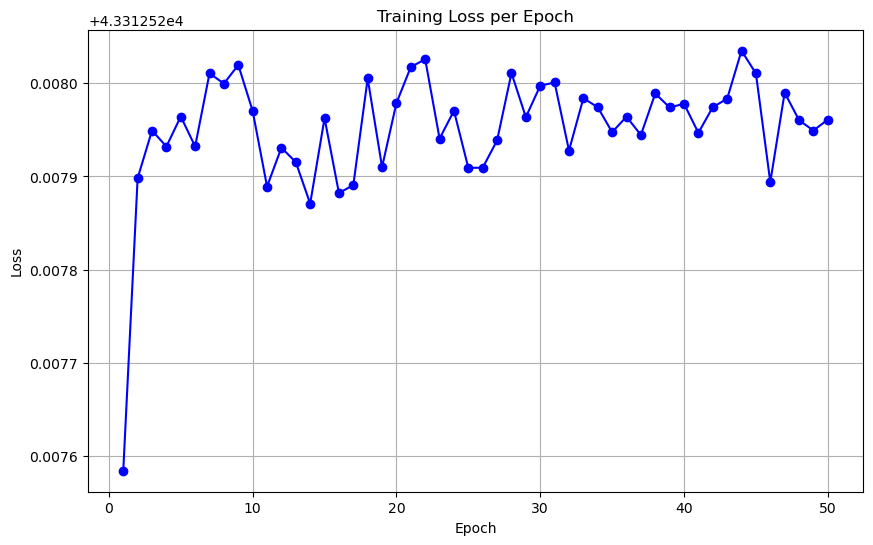

In [11]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), loss_values, marker='o', linestyle='-', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Given that your model deals with sequences of variable length, it's crucial to handle them correctly during prediction.

1. Flatten Predictions and Actuals
Instead of trying to convert the entire list of sequence outputs to a NumPy array, one can flatten the predictions and actuals to ensure they are of consistent shape.

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model.eval()
torch.set_grad_enabled(False)

Key Points:
1. .flatten() is used to convert each batch of predictions and actuals into a 1D array. This way, you avoid issues related to different sequence lengths within each batch.
2. Ensure that the flattening operation aligns with how your model processes the data. For instance, if your model outputs a single prediction per sequence, this flattening step is appropriate. If it outputs a prediction per time step in the sequence, this will aggregate all predictions across all sequences.
3. This approach assumes that each element in the output tensor corresponds to a label in the labels tensor. Make sure this holds true for your model's architecture and the nature of your task.

By flattening the predictions and actuals, you can avoid the error caused by trying to create a NumPy array from a list of arrays with varying shapes. This will allow you to correctly calculate the evaluation metrics for your model.

In [13]:
predictions, actuals = [], []
for sequences, labels in dataloader_test:
    outputs = model(sequences)
    
    # Flatten the outputs and labels
    predictions.extend(outputs.detach().numpy().flatten())
    actuals.extend(labels.numpy().flatten())

# Convert to NumPy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)
print(predictions)
print(actuals)
# Now calculate the metrics
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


[0.00018873 0.00018894 0.00018866 ... 0.00202298 0.00202514 0.0020265 ]
[-19.3716   -19.36883  -64.00126  ... -35.17176  -35.1188   -22.148876]
Mean Absolute Error (MAE): 317.1302
Mean Squared Error (MSE): 219509.4688
Root Mean Squared Error (RMSE): 468.5184
